In [2]:
import zipfile, os, math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
from numpy.random import randn, rand

# tidy default plotting
plt.rcParams.update({"figure.figsize": (8,4), "axes.grid": True})


Data loading

In [3]:
FILES = {
    "acc": "data/Accelerometer.csv",
    "gyr": "data/Gyroscope.csv",
    "trk": "data/Tracker_aligned.csv",
    "noise_acc": "data/noise_Acc",
    "noise_gyr": "data/noise_Gyr"
}

IMU

In [5]:
DIR = "../../data"

# Define file paths
file_paths = {
    "acc": "Accelerometer.csv", 
    "gyr": "Gyroscope.csv",
    "trk": "Tracker_aligned.csv",
    "noise_acc": "noise_Acc.csv",
    "noise_gyr": "noise_Gyr.csv"
}

# Load and clean all sensor CSVs (skip first row, promote second to header)
dataframes = {}
for key, path in file_paths.items():
    path = DIR + "/" + path
    # Read CSV file drop first column
    df = pd.read_csv(path, sep=",").iloc[:, 1:]
    dataframes[key] = df

# Print the first few rows of each dataframe
for key, df in dataframes.items():
    print(f"{key}:")
    print(df.head())

acc:
   seconds_elapsed         z         y         x
0         0.022852 -0.053982 -0.010348  0.040906
1         0.032818 -0.073131 -0.003087  0.017670
2         0.042782 -0.059809 -0.009220  0.015778
3         0.052749 -0.085699  0.003128  0.021464
4         0.062715 -0.068490  0.004616 -0.001712
gyr:
   seconds_elapsed         z         y         x
0         0.022852  0.000327 -0.003186  0.001806
1         0.032818  0.002338 -0.003803 -0.003158
2         0.042782 -0.001544 -0.001809 -0.000190
3         0.052749 -0.000979 -0.003310 -0.002376
4         0.062715  0.000285 -0.003655 -0.000411
trk:
   seconds_elapsed         x         y        vx        vy
0         0.022852 -0.000149  0.000461       NaN       NaN
1         0.032818 -0.000382  0.000577       NaN       NaN
2         0.042782 -0.000275  0.000802 -0.002461  0.012387
3         0.052749 -0.000162  0.001028  0.000937  0.007289
4         0.062715 -0.000049  0.001255  0.004335  0.002192
noise_acc:
   seconds_elapsed         z    

dt, matrix A and C

In [6]:
acc = dataframes["acc"]
dt = np.diff(acc["seconds_elapsed"].values).mean()
I3, O3 = np.eye(3), np.zeros((3,3))

A = np.block([[I3,         dt*I3, 0.5*(dt**2)*I3],
              [O3,             I3,          dt*I3],
              [O3,             O3,              I3]])

C = np.hstack([O3, O3, I3])

print("\Delta t =", dt, "\n")
print("State-Transition Matrix  A:\n", A, "\n")
print("Observation Matrix  C:\n", C)

\Delta t = 0.009965684267808292 

State-Transition Matrix  A:
 [[1.00000000e+00 0.00000000e+00 0.00000000e+00 9.96568427e-03
  0.00000000e+00 0.00000000e+00 4.96574315e-05 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  9.96568427e-03 0.00000000e+00 0.00000000e+00 4.96574315e-05
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 9.96568427e-03 0.00000000e+00 0.00000000e+00
  4.96574315e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 9.96568427e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 9.96568427e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  9.96568427e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0000

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10810/1796903004.py:11: SyntaxWarning: invalid escape sequence '\D'
  print("\Delta t =", dt, "\n")


noise covariance Q and R

In [7]:
sigma_acc, sigma_meas = 0.1, 0.05
Q = sigma_acc**2 * np.block([
    [0.25*dt**4*I3, 0.5*dt**3*I3, 0.5*dt**2*I3],
    [0.5*dt**3*I3,     dt**2*I3,      dt*I3  ],
    [0.5*dt**2*I3,        dt*I3,        I3    ]
])
R  = (sigma_meas**2)*I3
x0 = np.zeros((9,1));   P0 = np.eye(9)

Low-Pass Filter

In [20]:
from scipy.signal import butter, filtfilt
timestamps = gt.iloc[:, 0]  # assuming 1st column is time
dt = np.mean(np.diff(timestamps))
fs = 1.0 / dt  # sampling frequency

# Step 3: Butterworth Low-pass filter
def low_pass_filter(df, columns, cutoff=5.0, fs=100.0, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    df_filtered = df.copy()
    for col in columns:
        df_filtered[col] = filtfilt(b, a, df[col])
    return df_filtered

# Apply LPF to accelerometer
acc_lpf = low_pass_filter(acc, ['x', 'y', 'z'], cutoff=5.0, fs=fs, order=2)

orangize the data

In [25]:
acc       = dataframes['acc']
gyr       = dataframes['gyr']
acc_noise = dataframes['noise_acc']
gyr_noise = dataframes['noise_gyr']
gt        = dataframes['trk']

DATA = {
    "acc_raw"   : acc,
    "acc_lpf"   : acc_lpf,
    "gyr_raw"   : gyr,
    "acc_noise" : acc_noise,
    "gyr_noise" : gyr_noise,
    "truth"     : gt,
    "dt"        : dt,
    "A"         : A,
    "C"         : C,
    "Q"         : Q,
    "R"         : R,
    "x0"        : x0,
    "P0"        : P0
}


Process & measurement models

In [26]:
dt = DATA['dt']
def process_model(X):
    pos = X[:,0:3] + X[:,3:6]*dt + 0.5*X[:,6:9]*(dt**2)
    vel = X[:,3:6] + X[:,6:9]*dt
    acc = X[:,6:9]
    return np.hstack([pos, vel, acc])

def measurement_model(X):
    return X[:,6:9]          # accelerometer gives us acceleration

Particle Filter

In [28]:
def particle_filter(acc_meas, Np=20):
    T = len(acc_meas)
    particles = np.tile(DATA['x0'].ravel(), (Np,1))
    weights   = np.full(Np, 1.0/Np)
    est_path  = np.zeros((T,3))

    for k in range(T):
        # 1. Prediction
        particles = process_model(particles)
        particles += np.random.multivariate_normal(
                        mean=np.zeros(9), cov=DATA['Q'], size=Np)

        # 2. Weight update
        diffs      = acc_meas[k] - measurement_model(particles)
        mahal2     = np.sum(diffs @ np.linalg.inv(DATA['R']) * diffs, axis=1)
        weights   *= np.exp(-0.5*mahal2)
        weights   += 1e-300
        weights   /= weights.sum()

        # 3. Systematic resample
        cdf = np.cumsum(weights)
        u0  = np.random.uniform(0, 1.0/Np)
        idx = np.searchsorted(cdf, u0 + np.arange(Np)/Np)
        particles = particles[idx]
        weights.fill(1.0/Np)

        est_path[k] = particles[:,0:3].mean(axis=0)

    return est_path

Run and plot - PF

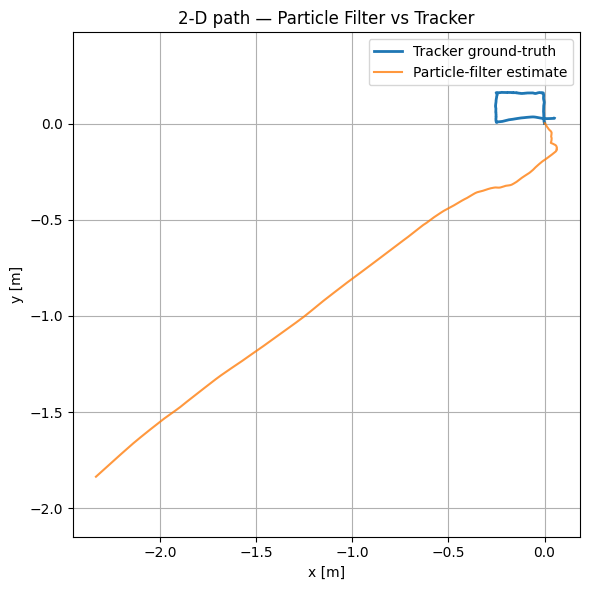

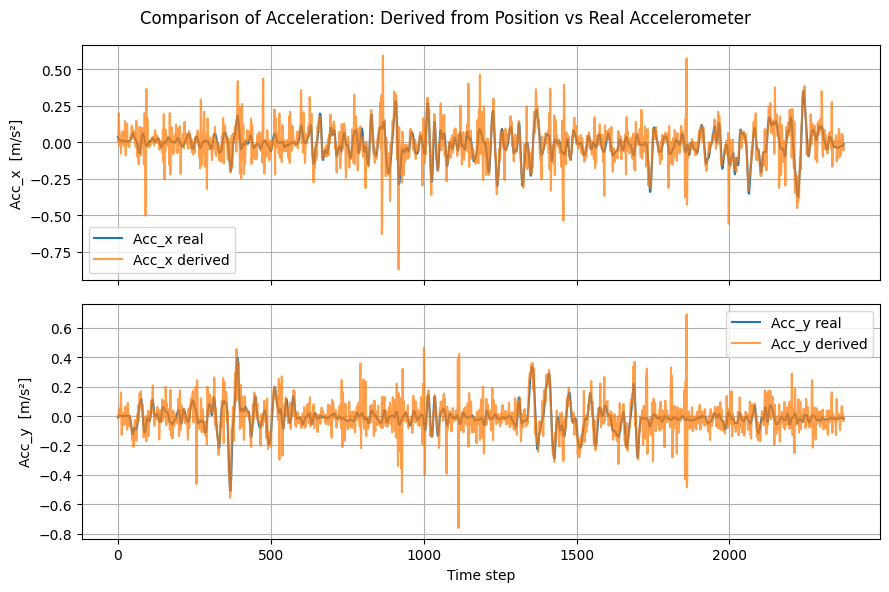

In [48]:
# ── 1. RUN THE FILTER ────────────────────────────────────────────────────────
acc_array = DATA['acc_lpf'][['x', 'y', 'z']].to_numpy()
pf_path   = particle_filter(acc_array, Np=20)          # ← adjust Np as desired
DATA['pf_path'] = pf_path

# ── 2. PLOT 2-D PATH  (tracker vs PF) ────────────────────────────────────────
gt_xy = DATA['truth'][['x','y']].values

plt.figure(figsize=(6,6))
plt.plot(gt_xy[:,0], gt_xy[:,1], label='Tracker ground-truth', lw=2)
plt.plot(pf_path[:,0], pf_path[:,1], label='Particle-filter estimate', alpha=0.8)
plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.title('2-D path — Particle Filter vs Tracker')
plt.axis('equal'); plt.legend(); plt.tight_layout()
plt.show()

# ── 3. DERIVE ACCEL FROM PF POSITIONS  &  COMPARE TO REAL ACCEL ──────────────
dt      = DATA['dt']
vel_pf  = np.gradient(pf_path, dt, axis=0)
acc_pf  = np.gradient(vel_pf, dt, axis=0)          # Âx, Ây, Âz
acc_pf  = acc_pf[1:-1]                             # align lengths
acc_real = DATA['acc_lpf'][['x', 'y', 'z']].values[1:-1]
t_steps  = np.arange(len(acc_pf))
fig, axs = plt.subplots(2, 1, figsize=(9,6), sharex=True)

axs[0].plot(t_steps, acc_real[:,0], label='Acc_x real')
axs[0].plot(t_steps, acc_pf[:,0],  label='Acc_x derived', alpha=0.75)
axs[0].set_ylabel('Acc_x  [m/s²]'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(t_steps, acc_real[:,1], label='Acc_y real')
axs[1].plot(t_steps, acc_pf[:,1],  label='Acc_y derived', alpha=0.75)
axs[1].set_ylabel('Acc_y  [m/s²]'); axs[1].set_xlabel('Time step')
axs[1].legend(); axs[1].grid(True)

fig.suptitle('Comparison of Acceleration: Derived from Position vs Real Accelerometer')
plt.tight_layout()
plt.show()

Klaman Filter

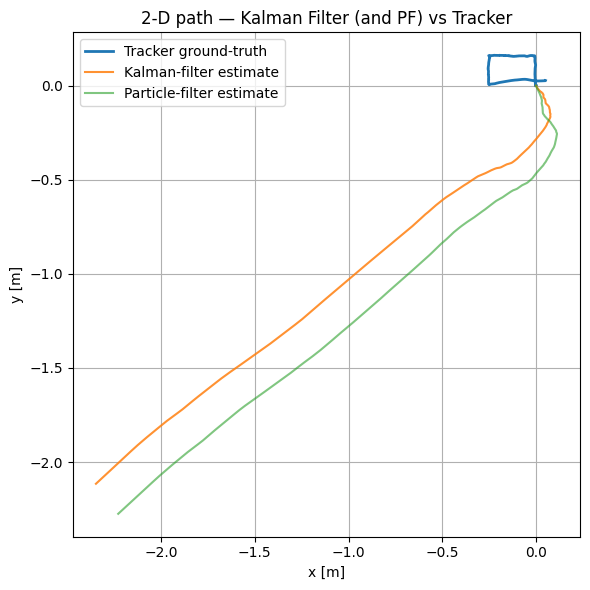

In [39]:
def kalman_filter(acc_meas, A, C, Q, R, x0, P0):
    """
    Linear Kalman filter for the 9-state [pos vel acc] model.
    acc_meas : (T,3)   low-pass-filtered accelerometer samples
    returns   : (T,9)  state history  [x y z  vx vy vz  ax ay az]
    """
    T  = len(acc_meas)
    nX = x0.shape[0]
    x  = x0.copy()          # (9,1)
    P  = P0.copy()          # (9,9)
    xs = np.zeros((T, nX))  # store

    for k in range(T):
        # Prediction
        x = A @ x
        P = A @ P @ A.T + Q

        # Update
        z   = acc_meas[k].reshape(3,1)
        y   = z - C @ x
        S   = C @ P @ C.T + R
        K   = P @ C.T @ np.linalg.inv(S)
        x   = x + K @ y
        P   = (np.eye(nX) - K @ C) @ P

        xs[k] = x.ravel()

    return xs

# ── 2. RUN THE FILTER ───────────────────────────────────────────────────────
acc_meas = DATA['acc_lpf'][['x', 'y', 'z']].values
kf_states = kalman_filter(acc_meas,
                          DATA['A'], DATA['C'],
                          DATA['Q'], DATA['R'],
                          DATA['x0'], DATA['P0'])

kf_path = kf_states[:, 0:3]          # positions are first 3 components
DATA['kf_path'] = kf_path            # stash for later comparisons

# ── 3. PLOT 2-D PATH  (ground-truth vs KF, optional PF) ─────────────────────
gt_xy = DATA['truth'][['x', 'y']].values

plt.figure(figsize=(6,6))
plt.plot(gt_xy[:,0], gt_xy[:,1], label='Tracker ground-truth', lw=2)
plt.plot(kf_path[:,0], kf_path[:,1], label='Kalman-filter estimate', alpha=0.85)

# optional: overlay PF if it exists
if 'pf_path' in DATA:
    plt.plot(DATA['pf_path'][:,0], DATA['pf_path'][:,1],
             label='Particle-filter estimate', alpha=0.6)

plt.xlabel('x [m]'); plt.ylabel('y [m]')
plt.title('2-D path — Kalman Filter (and PF) vs Tracker')
plt.axis('equal'); plt.legend(); plt.tight_layout()
plt.show()

KlamanNet - model

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

class KNet(nn.Module):
    def __init__(self, n_x=9, n_y=3, hidden=528, num_layers=3):
        super().__init__()
        self.n_x, self.n_y = n_x, n_y
        self.gru  = nn.GRU(input_size=n_y+n_x, hidden_size=hidden,
                           num_layers=num_layers, batch_first=True)
        self.fc   = nn.Sequential(nn.Linear(hidden, n_x*n_y))
        # register constant matrices so they move with .to(device)
        self.register_buffer("A", torch.from_numpy(DATA['A']).float())
        self.register_buffer("C", torch.from_numpy(DATA['C']).float())

    def forward(self, y_seq):
        """
        y_seq : (B,T,n_y)   – mini-batch of measurement sequences
        returns: (B,T,n_x)  – KalmanNet state estimates
        """
        B, T, _ = y_seq.shape
        h = torch.zeros(self.gru.num_layers, B, self.gru.hidden_size,
                        device=y_seq.device)
        # pre-allocate
        x_hat = torch.zeros(B, T, self.n_x, device=y_seq.device)

        # initialise with zeros
        x_prev = torch.zeros(B, self.n_x, device=y_seq.device)

        for t in range(T):
            # Predict step (classic model) ---------------------------------
            x_pred = (self.A @ x_prev.unsqueeze(-1)).squeeze(-1)  # (B,n_x)
            y_pred = (self.C @ x_pred.unsqueeze(-1)).squeeze(-1)  # (B,n_y)
            innov  = y_seq[:,t] - y_pred                          # (B,n_y)

            gru_in = torch.cat([innov, x_pred], dim=-1)           # (B,n_y+n_x)
            gru_out, h = self.gru(gru_in.unsqueeze(1), h)         # (B,1,H)
            K_t     = self.fc(gru_out.squeeze(1))                 # (B,n_x*n_y)
            K_t     = K_t.view(B, self.n_x, self.n_y)             # Kalman gain

            # Correct step -----------------------------------------------
            x_upd  = x_pred.unsqueeze(-1) + K_t @ innov.unsqueeze(-1)
            x_prev = x_upd.squeeze(-1)
            x_hat[:,t] = x_prev

        return x_hat

Using cpu


KN - training

In [42]:
seq_len, stride = 50, 5
dt              = DATA['dt']

# ---- ground-truth position ---------------------------------------------------
truth_df = DATA['truth'].copy()
if 'z' not in truth_df.columns:            # add zero-height if missing
    truth_df['z'] = 0.0
gt_pos = torch.tensor(truth_df[['x','y','z']].values,
                      dtype=torch.float32)

# ---- accelerometer (low-pass) ------------------------------------------------
acc_lpf = torch.tensor(
    DATA['acc_lpf'][['x', 'y', 'z']].values,
    dtype=torch.float32)

# ---- length-alignment  (trim both to min length) ----------------------------
T = min(len(acc_lpf), len(gt_pos))
acc_lpf = acc_lpf[:T]
gt_pos  = gt_pos[:T]

# ---- differentiate to get vel & acc -----------------------------------------
vel_gt = torch.diff(gt_pos, dim=0, prepend=gt_pos[0:1]) / dt
acc_gt = torch.diff(vel_gt, dim=0, prepend=vel_gt[0:1]) / dt
state_gt = torch.cat([gt_pos, vel_gt, acc_gt], dim=1)      # (T,9)

# ---- window into mini-sequences ---------------------------------------------
def windowed(x, L, s):
    idx = torch.arange(0, x.shape[0]-L+1, s)
    return torch.stack([x[i:i+L] for i in idx])

Y = windowed(acc_lpf,  seq_len, stride)   # (N,L,3)  measurements
X = windowed(state_gt, seq_len, stride)   # (N,L,9)  targets

split = int(0.8 * len(Y))
Y_train, Y_val = Y[:split], Y[split:]
X_train, X_val = X[:split], X[split:]


# ---- training loop---------------------------------------
import torch.optim as optim

def train_knet(model, Ytr, Xtr, Yval, Xval, epochs=30, lr=1e-3):
    model.to(device)
    opt  = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        pred = model(Ytr.to(device))
        loss = loss_fn(pred, Xtr.to(device))
        loss.backward(); opt.step()

        # ---- validation
        model.eval()
        with torch.no_grad():
            val = loss_fn(model(Yval.to(device)), Xval.to(device)).item()
        if ep % 5 == 0 or ep == 1:
            print(f"epoch {ep:3d}  train={loss.item():.4e}  val={val:.4e}")

    return model

knet = train_knet(KNet(), Y_train, X_train, Y_val, X_val,
                  epochs=40, lr=1e-3)

epoch   1  train=1.2267e-01  val=7.3980e-02
epoch   5  train=1.1806e-01  val=7.4465e-02
epoch  10  train=1.1640e-01  val=7.1842e-02
epoch  15  train=1.1787e-01  val=7.4463e-02
epoch  20  train=1.1834e-01  val=7.4701e-02
epoch  25  train=1.1806e-01  val=7.4701e-02
epoch  30  train=1.1761e-01  val=7.4753e-02
epoch  35  train=1.1711e-01  val=7.4932e-02
epoch  40  train=1.1654e-01  val=7.5193e-02


KN- FULL-SEQUENCE INFERENCE  +  PLOTS

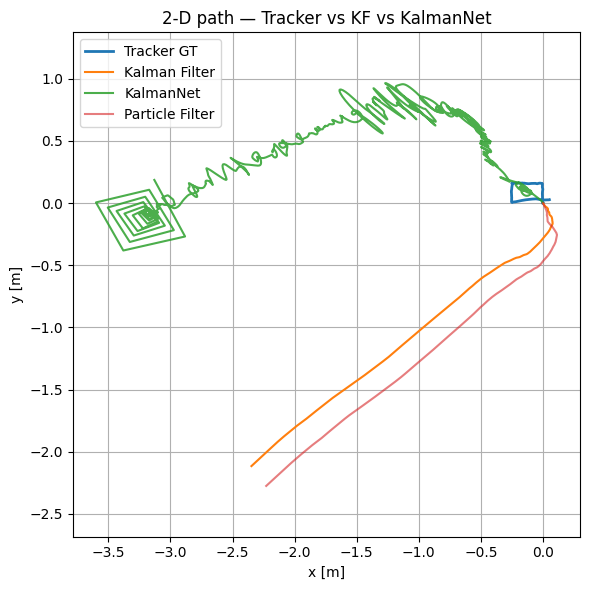

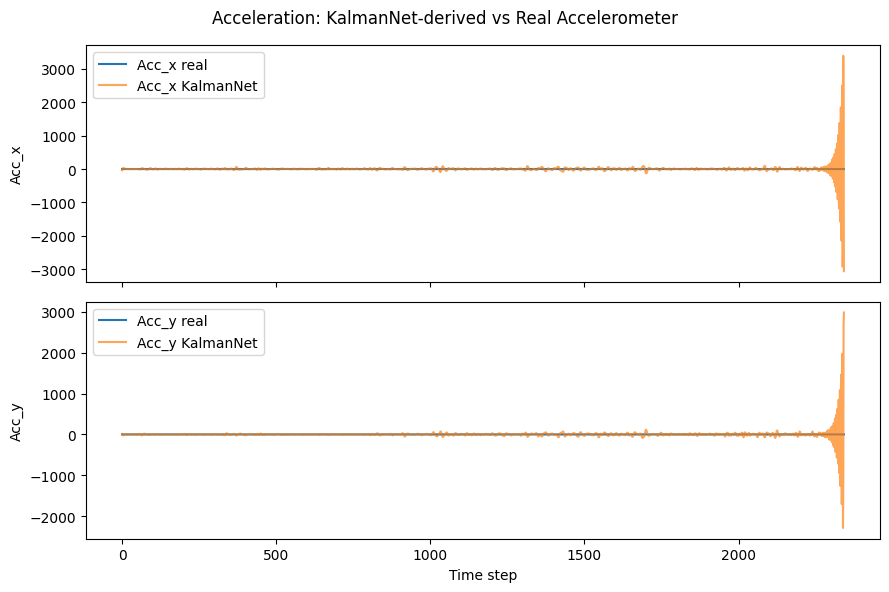

In [43]:
knet.eval()
with torch.no_grad():
    knet_states = knet(acc_lpf.unsqueeze(0).to(device)).cpu().squeeze(0).numpy()
knet_path = knet_states[:,0:3]
DATA['knet_path'] = knet_path
DATA['acc_lpf_trimmed'] = acc_lpf        # keep the synced version

# ---- PATH PLOT ----------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(DATA['truth']['x'], DATA['truth']['y'], label='Tracker GT', lw=2)
plt.plot(DATA['kf_path'][:,0],  DATA['kf_path'][:,1],  label='Kalman Filter')
plt.plot(knet_path[:,0],        knet_path[:,1],        label='KalmanNet', alpha=0.85)
if 'pf_path' in DATA:
    plt.plot(DATA['pf_path'][:,0], DATA['pf_path'][:,1], label='Particle Filter', alpha=0.6)
plt.xlabel('x [m]'); plt.ylabel('y [m]'); plt.axis('equal')
plt.title('2-D path — Tracker vs KF vs KalmanNet')
plt.legend(); plt.tight_layout(); plt.show()

# ---- ACCELERATION COMPARISON (derived vs real) --------------------------------
dt     = DATA['dt']
vel_kn = np.gradient(knet_path, dt, axis=0)
acc_kn = np.gradient(vel_kn, dt, axis=0)[1:-1]
acc_rl = DATA['acc_lpf_trimmed'][1:-1]        # synced real accel
ts     = np.arange(len(acc_kn))

fig,axs = plt.subplots(2,1,figsize=(9,6),sharex=True)
axs[0].plot(ts, acc_rl[:,0], label='Acc_x real')
axs[0].plot(ts, acc_kn[:,0], label='Acc_x KalmanNet', alpha=0.7)
axs[0].set_ylabel('Acc_x'); axs[0].grid(); axs[0].legend()

axs[1].plot(ts, acc_rl[:,1], label='Acc_y real')
axs[1].plot(ts, acc_kn[:,1], label='Acc_y KalmanNet', alpha=0.7)
axs[1].set_ylabel('Acc_y'); axs[1].set_xlabel('Time step'); axs[1].grid(); axs[1].legend()

fig.suptitle('Acceleration: KalmanNet-derived vs Real Accelerometer')
plt.tight_layout(); plt.show()

comparison tables and graph